In [1]:
import pyximport; pyximport.install()
from gpcode import *
from csvparser import *

import math

In [2]:
def handMapToVector(handResults_dict):
    result = []
    
    mapping = {'raise': 1.0, 'check': 0.5, 'fold': 0.0}
    
    keys = handResults_dict.keys()
    keys = sorted(keys)
    
    sub_keys = handResults_dict[0].keys()
    sub_keys = sorted(sub_keys)
    
    for i in keys:
        result.append([])
        for j in range(0,len(sub_keys)):
            data = handResults_dict[i][sub_keys[j]]
            
            result[i].append(mapping[data])
    
    return result

In [3]:
def distance(v1, v2):
    result = 0.0
    
    for i in range(len(v1)):
        #temp = 0.0
        for j in range(len(v1[i])):
            if v2[i][j] != v1[i][j]:
                result += 1.0
            #result += (v2[i][j] - v1[i][j]) ** 2
    
    #return math.sqrt(result)
    return result

In [11]:
#ind = gp.PrimitiveTree.from_string("'raise'", pset)
#ind2 = gp.PrimitiveTree.from_string("'check'", pset)
#ind3 = gp.PrimitiveTree.from_string("'fold'", pset)
#i = handMapToVector(mapHandsToResults(ind, all_hands))
#j = handMapToVector(mapHandsToResults(ind2, all_hands))
#k = handMapToVector(mapHandsToResults(ind3, all_hands))

45.9619407771
91.9238815543
45.9619407771


In [4]:
csv_filename = "Comparison Results/mapping-" + machine_alias + ".csv.txt"

fields = [['Heuristic'], ['Complexity'], ['Fitness']]
conditions = []

csv_data = extractDictFromCSV(csv_filename)
parsed_data = extractIndividualsFromData(csv_data, ind_field=fields[0], complexity_field= fields[1], fitness_field=fields[2], condition=conditions)
parsed_data = sorted(parsed_data, reverse=True)

In [130]:
ind_c = gp.PrimitiveTree.from_string("check", pset)
v2 = handMapToVector(mapHandsToResults(ind_c, all_hands))

ind_r = gp.PrimitiveTree.from_string("raise", pset)
v3 = handMapToVector(mapHandsToResults(ind_r, all_hands))

ind_f = gp.PrimitiveTree.from_string("fold", pset)
v4 = handMapToVector(mapHandsToResults(ind_f, all_hands))

for p in parsed_data:
    ind1 = gp.PrimitiveTree.from_string(p.heuristic, pset)
    v1 = handMapToVector(mapHandsToResults(ind1, all_hands))
    p.dist_c = distance(v1, v2)
    p.dist_r = distance(v1, v3)
    p.dist_f = distance(v1, v4)

In [88]:
plot_data = []

for ind in parsed_data:
    plot_data.append([ind.dist_c, ind.dist_r, ind.fitness, ind.cluster_index])

In [124]:
import matplotlib.pyplot as plt

%matplotlib inline

def scatterplot(x, y, z, centers, cluster_index):#, data):
    fig, ax = plt.subplots()
    fig.set_size_inches(30.0, 30.0)

    ax = plt.subplot(326)
    #markers = [(5,2), ">", (5, 0), (5, 1), '+']
    #colors = [(1,0,0), (0,1,0), (0,0,1), (1,1,0), (0,1,1)]
    
    colors = [(1, 0, 0), (1, 0.5, 0), (1, 1, 0), (0, 1, 0), (0, 0, 1), (0.3, 0, 0.5), (0.56, 0, 1), (0, 0, 0)]
    
    #z_min = min(z)
    #z_diff = max(z) - z_min
    
    for i in range(0, len(x)):
        #red = (z[i] - z_min) / z_diff
        plt.scatter(x[i], y[i], s=80, c=colors[cluster_index[i]], marker='o')
    
    count = 1
    for x, y in centers:
        plt.scatter(y, x, s=80, c=(0.5, 0.5, 0.5), marker="*")
        if count != 3:
            ax.annotate(str(count), (y, x), xytext=(y+20., x+20.), size=18)
        else:
            ax.annotate(str(count), (y, x), xytext=(y+2., x-270.), size=18)
        count += 1

    ax.set_xlabel('Distance to Always Check', fontsize=20)
    ax.set_ylabel('Distance to Always Raise', fontsize=20)
    
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    
    plt.show()

def createPointsLineOnScatter(data):
    data_dict = {}
    for d in data:
        if d[1] not in data_dict:
            data_dict[d[1]] = [d[0]]
        else:
            data_dict[d[1]].append(d[0])

    points = []
    for key in data_dict:
        points.append((key, max(data_dict[key])))

    return points

def createLineInScatter(points):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    
    plt.plot(x, y, c='r')

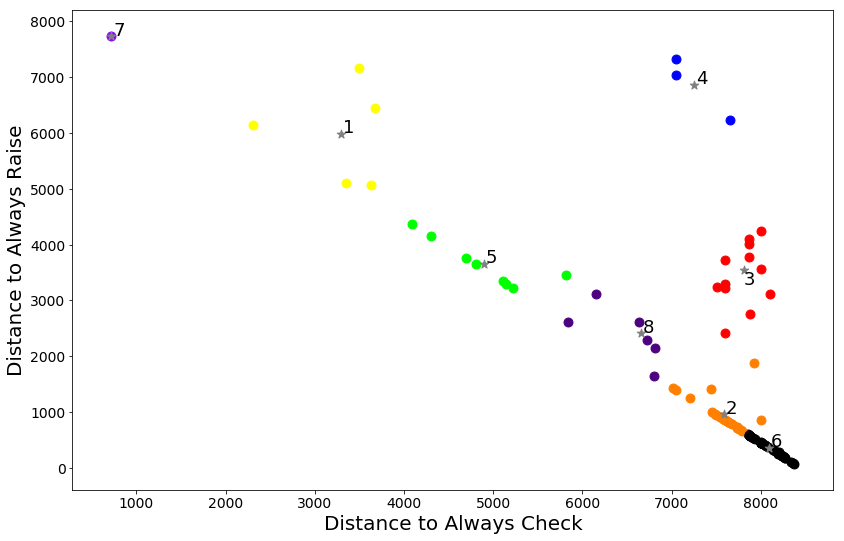

In [125]:
from sklearn.cluster import KMeans
import numpy as np


#temp = [d for d in plot_data if d[2] > -0.25]
temp = sorted(plot_data, key=lambda d: d[2])
#temp = plot_data

aux = [(d[0], d[1]) for d in temp]
X = np.array(aux)
kmeans = KMeans(n_clusters=8, random_state=0, n_init=1000).fit(X)
kmeans_indexes = KMeans(n_clusters=8, random_state=0).fit_predict(X)
#kmeans.labels_
#kmeans.predict([[0, 0], [4, 4]])
centers = kmeans.cluster_centers_

x = [d[1] for d in temp]
y = [d[0] for d in temp]
z = [d[2] for d in temp]
cindex = [d[3] for d in temp]

scatterplot(x, y, z, centers, cindex)#, plot_data)

In [131]:
fitness_array = []
dist_r_array = []
dist_c_array = []
dist_f_array = []

for i in range(len(parsed_data)):
    ind = parsed_data[i]
    fitness_array.append(ind.fitness)
    dist_r_array.append(ind.dist_r)
    dist_c_array.append(ind.dist_c)
    dist_f_array.append(ind.dist_f)

fitness_array = np.array(fitness_array)
dist_r_array = np.array(dist_r_array)
dist_c_array = np.array(dist_c_array)
dist_f_array = np.array(dist_f_array)

print "Correlation Fitness, Distance Raise ", np.corrcoef([fitness_array,dist_r_array])[1,0]
print "Correlation Fitness, Distance Check ", np.corrcoef([fitness_array,dist_c_array])[1,0]
print "Correlation Fitness, Distance Fold ", np.corrcoef([fitness_array,dist_f_array])[1,0]

Correlation Fitness, Distance Raise  0.00025847218233688776
Correlation Fitness, Distance Check  0.08996112775874558
Correlation Fitness, Distance Fold  -0.1343573687407719


In [87]:
cluster_dict = {}

for i in range(len(aux)):
    for p in parsed_data:
        x = aux[i][0]
        y = aux[i][1]
        
        if p.dist_c == x and p.dist_r == y:
            index = kmeans_indexes[i]
            
            if index not in cluster_dict:
                cluster_dict[index] = []
            
            p.cluster_index = index
            cluster_dict[index].append(p)


output_csv_filename = "Distance Results/Most-distant-" + machine_alias + "-" + str(datetime.datetime.now()) + ".csv.txt"
if not os.path.isfile(output_csv_filename):
    createLogFile(output_csv_filename, "Heuristic; Fitness; Distance_r; Distance_c;\n")
            
for k in cluster_dict.keys():
    temp = max(cluster_dict[k], key=lambda d : d.fitness)
    logToFile(output_csv_filename, temp.heuristic + "; " + str(temp.fitness) + "; " + str(temp.dist_r) + "; " + str(temp.dist_c) + ";\n")
    #print temp

In [13]:
results = {}

csv_filename = "Distance Results/mapping-" + machine_alias + "-" + str(datetime.datetime.now()) + ".csv.txt"
if not os.path.isfile(csv_filename):
    createLogFile(csv_filename, "Heuristic1; Heuristic2; Distance;\n")

c = 0
print c
for x in parsed_data:
    results[x.heuristic] = 0.
    ind1 = gp.PrimitiveTree.from_string(x.heuristic, pset)
    v1 = handMapToVector(mapHandsToResults(ind1, all_hands))

    for y in parsed_data:
        if x.heuristic != y.heuristic:
            ind2 = gp.PrimitiveTree.from_string(y.heuristic, pset)

            v2 = handMapToVector(mapHandsToResults(ind2, all_hands))
            
            d = distance(v1, v2)

            logToFile(csv_filename, str(ind1) + "; " + str(ind2) + "; "  + str(d) + ";\n")
            results[x.heuristic] += d
    c += 1
    print c

print results

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


NameError: name 'result' is not defined